
# Bayesian Optimization
# Optimizing the SGD Learning Rate when Training a Neural Network

### Roger Garrida
### Akhil Lohia
### Daniel Velasquez

# Introduction 


Training a neural network can be a difficult task. In particular, due to the large number of hyperparameters that need to be tunned, e.g. number of layers, number of hidden units, batch size among other. In this project, we focus on one particular hyperparameter that influence directly the success of the learning procedure: The stochastic gradient descent **learning rate **. We use bayesian optimization to tune the learning rate and compare the results with a grid search.

In [11]:
#Required libraries
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import math as mat
import scipy
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm #add progress bar to for loops
import math

## Gaussian Process

In [2]:
def gaussian_kernel(x1,x2,noise,length): #Generate the kernel (cov) of the Gaussian Process
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    kernel = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            kernel[i,j] = noise**2*mat.exp(-0.5*((x1[i]-x2[j])/length)**2)
    return kernel


In [3]:
def LLH_GP(x,y,m,noise,length, sf = 0): #Compute the likelihood of the data (add sf if consider noise)
    ker = gaussian_kernel(x,x, noise, length)
    ker = ker+np.diag([sf]*len(x))
    return 1/2*(mat.log(np.linalg.det(ker))+np.dot(np.dot(np.transpose(y-m),
                                                       np.linalg.inv(ker)),(y-m)))


In [4]:
def opt_hyparams(x,y): #Find the hyperparameters that optimize LLH without noise
    ini = np.array([0,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], params[1], params[2]),
                            ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = 0.001
    return m, noise, length, sf  

In [5]:
def opt_hyparams_noise(x,y): #Find the hyperparameters that optimize LLH with noise
    ini = np.array([0,1,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], 
                                                  params[1], params[2], params[3]),ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = abs(params[3])
    return m, noise, length, sf

In [6]:
#Generates the mean and covariance of the posterior distribution in the given grid (xn) 
#from data (x,y) and the optimized parameters (mean->m, noise, length, noise in y -> sf)
def gp_posterior(x, y, xn, m, noise, length, sf = 0): 
    kxx = gaussian_kernel(x, x, noise = noise, length = length)
    kxxn = gaussian_kernel(x, xn, noise = noise, length = length)
    kxnx = gaussian_kernel(xn, x, noise = noise, length = length)
    kxnxn = gaussian_kernel(xn, xn, noise = noise, length = length)
    core = np.linalg.inv(kxx + np.diag([sf]*len(x)))
    En = np.dot(np.dot(kxnx, core), y)
    covn = kxnxn - np.dot(np.dot(kxnx, core), kxxn)  
    
    return En, covn

In [7]:
def data_posterior(x, E, cov):
    data = pd.DataFrame({'x': x})
    data['Mean'] = E
    data['StdDev'] = np.sqrt(np.diag(cov))
    #Generate the 5 samples as multivariate normals with 0 mean and covariance sigma
    for i in range(5):
        data['y'+str(i)] = np.random.multivariate_normal(E, cov)
    return data


# Neural Network Architecture and Dataset

Our goal is to perform classification on the MNIST dataset. To do so, we build a neural network with one hidden layer and a fixed number of hidden units. We divide the dataset in training and test sample. We define a function that trains the network as a function of the learning rate and returns a measure of accuracy estimated using the test sample. The accuracy corresponds the number of correctly classified observations divided by the total number of observations within the test sample. 

In [8]:
#MNIST dataset:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, validation_size=0)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
#placeholder:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

##Variables:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    #initial = tf.ones(shape)/10
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def neural_network(input, h_dim):
    W0 = weight_variable([784, h_dim])
    b0 = bias_variable([h_dim])
    h = tf.nn.relu(tf.matmul(input, W0) + b0)

    W = weight_variable([h_dim, 10])
    b = bias_variable([10])

    y = tf.nn.softmax(tf.matmul(h, W) + b)
    return y

#Network training:
def nn_train(learning_rate, h_dim, minibatch = 100):
    y = neural_network(x, h_dim)
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))*minibatch
    #train_step = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    #n_samples = len(mnist.train.images)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.global_variables_initializer().run()
    for i in range(10000+1):
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        
        if (i%20 == 0): #Training accuracy update
            a, c = sess.run([accuracy, cross_entropy], {x: batch_xs, y_: batch_ys})
            print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        if (i%100 == 0): #Test accuracy update
            a, c = sess.run([accuracy, cross_entropy], {x: mnist.test.images, y_: mnist.test.labels})
            print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


# Network training with variable learning rate

def nn_train_var(min_lr, max_lr, h_dim, minibatch = 100):
    
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    
    y = neural_network(x, h_dim)
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))*minibatch
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)
    #train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
    
    tf.global_variables_initializer().run()
    
    for i in range(10000+1):
        # learning rate decay
        decay_speed = 2000.0
        learning_rate = min_lr + (max_lr - min_lr) * math.exp(-i/decay_speed)
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        
        if (i%20 == 0):
            a, c = sess.run([accuracy, cross_entropy], {x: batch_xs, y_: batch_ys})
            print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        if (i%100 == 0):
            a, c = sess.run([accuracy, cross_entropy], {x: mnist.test.images, y_: mnist.test.labels})
            print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, lr:learning_rate})

    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

# Adquisition Function

We start with a gaussian prior on the hyperparameters. We define an adquisicion function that allows us to select a new learning rate to test. In particular we use *Expected Improvement*. With each new value, we train the network and use the output (i.e. the classification accuracy) to update the prior density. Notice that in this case, we want maximize the accuracy. 

In [10]:
#Adquisition function

def acquisition_fun(x, y, xn, mean_vector, sigma_vector):
    x_best = x[np.argmax(y)]
    y_best = np.max(y)
    ind_cand = np.array([not any(abs(xi-x)<=0.00001) for xi in xn]) #Indicator of candidates
    gamma = (mean_vector[ind_cand] - y_best)/sigma_vector[ind_cand]
    af = (mean_vector[ind_cand] - y_best)* norm.cdf(gamma) + sigma_vector[ind_cand]*norm.pdf(gamma)

    x_next = xn[ind_cand][np.argmax(af)]
    return x_next


# Algorithm


Initially, we assume we only observe 2 potential learning rates and their corresponding accuracy. We implement an algorithm that, given some prior on the learning rate, at each iteration the acquisition function selects a new candidate learning rate, then trains the network and estimates the posterior density. The plots below shows inital observations, the mean and 1 standard deviation around the mean. 

When implementing the algorith we can assume that the observed accuracies contains noise or not. Given that in practice the classification accuracy of the neural network is not a deterministic function of the learning rate, we assume the observe values contain some noise. 

  0%|          | 0/2 [00:00<?, ?it/s]

0: accuracy:0.13 loss: 229.158 (lr:0.1)
0: ********* epoch 1 ********* test accuracy:0.1508 test loss: 229.574
20: accuracy:0.08 loss: 238.114 (lr:0.1)
40: accuracy:0.08 loss: 237.664 (lr:0.1)
60: accuracy:0.46 loss: 200.742 (lr:0.1)
80: accuracy:0.51 loss: 194.898 (lr:0.1)
100: accuracy:0.55 loss: 191.714 (lr:0.1)
100: ********* epoch 1 ********* test accuracy:0.5656 test loss: 188.776
120: accuracy:0.71 loss: 175.5 (lr:0.1)
140: accuracy:0.79 loss: 166.136 (lr:0.1)
160: accuracy:0.83 loss: 164.376 (lr:0.1)
180: accuracy:0.84 loss: 162.823 (lr:0.1)
200: accuracy:0.8 loss: 164.411 (lr:0.1)
200: ********* epoch 1 ********* test accuracy:0.8333 test loss: 162.753
220: accuracy:0.85 loss: 160.31 (lr:0.1)
240: accuracy:0.85 loss: 161.085 (lr:0.1)
260: accuracy:0.9 loss: 156.509 (lr:0.1)
280: accuracy:0.84 loss: 161.963 (lr:0.1)
300: accuracy:0.86 loss: 159.243 (lr:0.1)
300: ********* epoch 1 ********* test accuracy:0.9007 test loss: 156.126
320: accuracy:0.92 loss: 155.069 (lr:0.1)
340: ac

2880: accuracy:0.97 loss: 149.101 (lr:0.1)
2900: accuracy:0.9 loss: 155.771 (lr:0.1)
2900: ********* epoch 5 ********* test accuracy:0.9358 test loss: 152.554
2920: accuracy:0.94 loss: 151.835 (lr:0.1)
2940: accuracy:0.96 loss: 150.193 (lr:0.1)
2960: accuracy:0.97 loss: 149.115 (lr:0.1)
2980: accuracy:0.94 loss: 152.113 (lr:0.1)
3000: accuracy:0.91 loss: 155.124 (lr:0.1)
3000: ********* epoch 6 ********* test accuracy:0.9189 test loss: 154.21
3020: accuracy:0.9 loss: 155.694 (lr:0.1)
3040: accuracy:0.97 loss: 149.697 (lr:0.1)
3060: accuracy:0.91 loss: 154.532 (lr:0.1)
3080: accuracy:0.92 loss: 154.117 (lr:0.1)
3100: accuracy:0.94 loss: 152.203 (lr:0.1)
3100: ********* epoch 6 ********* test accuracy:0.9398 test loss: 152.141
3120: accuracy:0.94 loss: 151.841 (lr:0.1)
3140: accuracy:0.9 loss: 156.201 (lr:0.1)
3160: accuracy:0.96 loss: 150.613 (lr:0.1)
3180: accuracy:0.94 loss: 152.115 (lr:0.1)
3200: accuracy:0.93 loss: 152.984 (lr:0.1)
3200: ********* epoch 6 ********* test accuracy:0.9

5720: accuracy:0.94 loss: 152.115 (lr:0.1)
5740: accuracy:0.94 loss: 152.115 (lr:0.1)
5760: accuracy:0.96 loss: 150.092 (lr:0.1)
5780: accuracy:0.9 loss: 155.345 (lr:0.1)
5800: accuracy:0.89 loss: 157.477 (lr:0.1)
5800: ********* epoch 10 ********* test accuracy:0.9364 test loss: 152.478
5820: accuracy:0.95 loss: 151.121 (lr:0.1)
5840: accuracy:0.91 loss: 155.067 (lr:0.1)
5860: accuracy:0.96 loss: 150.182 (lr:0.1)
5880: accuracy:0.92 loss: 154.524 (lr:0.1)
5900: accuracy:0.95 loss: 151.47 (lr:0.1)
5900: ********* epoch 10 ********* test accuracy:0.9449 test loss: 151.628
5920: accuracy:0.91 loss: 155.115 (lr:0.1)
5940: accuracy:0.95 loss: 151.115 (lr:0.1)
5960: accuracy:0.94 loss: 152.48 (lr:0.1)
5980: accuracy:0.93 loss: 153.156 (lr:0.1)
6000: accuracy:0.95 loss: 151.115 (lr:0.1)
6000: ********* epoch 11 ********* test accuracy:0.9178 test loss: 154.327
6020: accuracy:0.97 loss: 149.096 (lr:0.1)
6040: accuracy:0.95 loss: 151.115 (lr:0.1)
6060: accuracy:0.97 loss: 149.326 (lr:0.1)
6080

8600: accuracy:0.94 loss: 152.122 (lr:0.1)
8600: ********* epoch 15 ********* test accuracy:0.9395 test loss: 152.135
8620: accuracy:0.94 loss: 152.115 (lr:0.1)
8640: accuracy:0.96 loss: 150.104 (lr:0.1)
8660: accuracy:0.92 loss: 154.248 (lr:0.1)
8680: accuracy:0.98 loss: 148.115 (lr:0.1)
8700: accuracy:0.94 loss: 152.117 (lr:0.1)
8700: ********* epoch 15 ********* test accuracy:0.9408 test loss: 152.042
8720: accuracy:0.94 loss: 152.106 (lr:0.1)
8740: accuracy:0.94 loss: 152.112 (lr:0.1)
8760: accuracy:0.97 loss: 148.847 (lr:0.1)
8780: accuracy:0.96 loss: 150.09 (lr:0.1)
8800: accuracy:0.96 loss: 150.115 (lr:0.1)
8800: ********* epoch 15 ********* test accuracy:0.9432 test loss: 151.797
8820: accuracy:0.97 loss: 149.115 (lr:0.1)
8840: accuracy:0.89 loss: 157.01 (lr:0.1)
8860: accuracy:0.97 loss: 149.115 (lr:0.1)
8880: accuracy:0.95 loss: 151.115 (lr:0.1)
8900: accuracy:0.99 loss: 147.128 (lr:0.1)
8900: ********* epoch 15 ********* test accuracy:0.9478 test loss: 151.334
8920: accuracy

 50%|█████     | 1/2 [00:30<00:30, 30.28s/it]

10000: ********* epoch 17 ********* test accuracy:0.9442 test loss: 151.669
0: accuracy:0.14 loss: 229.555 (lr:0.8)
0: ********* epoch 1 ********* test accuracy:0.0921 test loss: 230.601
20: accuracy:0.11 loss: 235.115 (lr:0.8)
40: accuracy:0.12 loss: 234.115 (lr:0.8)
60: accuracy:0.08 loss: 238.115 (lr:0.8)
80: accuracy:0.08 loss: 238.115 (lr:0.8)
100: accuracy:0.1 loss: 236.115 (lr:0.8)
100: ********* epoch 1 ********* test accuracy:0.1032 test loss: 235.79
120: accuracy:0.11 loss: 235.115 (lr:0.8)
140: accuracy:0.11 loss: 235.115 (lr:0.8)
160: accuracy:0.07 loss: 239.115 (lr:0.8)
180: accuracy:0.04 loss: 242.115 (lr:0.8)
200: accuracy:0.07 loss: 239.115 (lr:0.8)
200: ********* epoch 1 ********* test accuracy:0.1032 test loss: 235.79
220: accuracy:0.11 loss: 235.115 (lr:0.8)
240: accuracy:0.12 loss: 234.115 (lr:0.8)
260: accuracy:0.04 loss: 242.115 (lr:0.8)
280: accuracy:0.04 loss: 242.115 (lr:0.8)
300: accuracy:0.09 loss: 237.115 (lr:0.8)
300: ********* epoch 1 ********* test accura

2880: accuracy:0.15 loss: 231.115 (lr:0.8)
2900: accuracy:0.04 loss: 242.115 (lr:0.8)
2900: ********* epoch 5 ********* test accuracy:0.1028 test loss: 235.83
2920: accuracy:0.07 loss: 239.115 (lr:0.8)
2940: accuracy:0.03 loss: 243.115 (lr:0.8)
2960: accuracy:0.08 loss: 238.115 (lr:0.8)
2980: accuracy:0.15 loss: 231.115 (lr:0.8)
3000: accuracy:0.1 loss: 236.115 (lr:0.8)
3000: ********* epoch 6 ********* test accuracy:0.1028 test loss: 235.83
3020: accuracy:0.13 loss: 233.115 (lr:0.8)
3040: accuracy:0.17 loss: 229.115 (lr:0.8)
3060: accuracy:0.09 loss: 237.115 (lr:0.8)
3080: accuracy:0.1 loss: 236.115 (lr:0.8)
3100: accuracy:0.14 loss: 232.115 (lr:0.8)
3100: ********* epoch 6 ********* test accuracy:0.1028 test loss: 235.83
3120: accuracy:0.1 loss: 236.115 (lr:0.8)
3140: accuracy:0.14 loss: 232.115 (lr:0.8)
3160: accuracy:0.14 loss: 232.115 (lr:0.8)
3180: accuracy:0.1 loss: 236.115 (lr:0.8)
3200: accuracy:0.05 loss: 241.115 (lr:0.8)
3200: ********* epoch 6 ********* test accuracy:0.1028

5760: accuracy:0.13 loss: 233.115 (lr:0.8)
5780: accuracy:0.17 loss: 229.115 (lr:0.8)
5800: accuracy:0.12 loss: 234.115 (lr:0.8)
5800: ********* epoch 10 ********* test accuracy:0.1028 test loss: 235.83
5820: accuracy:0.1 loss: 236.115 (lr:0.8)
5840: accuracy:0.1 loss: 236.115 (lr:0.8)
5860: accuracy:0.15 loss: 231.115 (lr:0.8)
5880: accuracy:0.11 loss: 235.115 (lr:0.8)
5900: accuracy:0.1 loss: 236.115 (lr:0.8)
5900: ********* epoch 10 ********* test accuracy:0.1028 test loss: 235.83
5920: accuracy:0.13 loss: 233.115 (lr:0.8)
5940: accuracy:0.18 loss: 228.115 (lr:0.8)
5960: accuracy:0.1 loss: 236.115 (lr:0.8)
5980: accuracy:0.12 loss: 234.115 (lr:0.8)
6000: accuracy:0.08 loss: 238.115 (lr:0.8)
6000: ********* epoch 11 ********* test accuracy:0.1028 test loss: 235.83
6020: accuracy:0.09 loss: 237.115 (lr:0.8)
6040: accuracy:0.07 loss: 239.115 (lr:0.8)
6060: accuracy:0.13 loss: 233.115 (lr:0.8)
6080: accuracy:0.11 loss: 235.115 (lr:0.8)
6100: accuracy:0.08 loss: 238.115 (lr:0.8)
6100: **

8600: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8620: accuracy:0.13 loss: 233.115 (lr:0.8)
8640: accuracy:0.11 loss: 235.115 (lr:0.8)
8660: accuracy:0.09 loss: 237.115 (lr:0.8)
8680: accuracy:0.09 loss: 237.115 (lr:0.8)
8700: accuracy:0.11 loss: 235.115 (lr:0.8)
8700: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8720: accuracy:0.1 loss: 236.115 (lr:0.8)
8740: accuracy:0.11 loss: 235.115 (lr:0.8)
8760: accuracy:0.14 loss: 232.115 (lr:0.8)
8780: accuracy:0.15 loss: 231.115 (lr:0.8)
8800: accuracy:0.1 loss: 236.115 (lr:0.8)
8800: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8820: accuracy:0.06 loss: 240.115 (lr:0.8)
8840: accuracy:0.1 loss: 236.115 (lr:0.8)
8860: accuracy:0.16 loss: 230.115 (lr:0.8)
8880: accuracy:0.15 loss: 231.115 (lr:0.8)
8900: accuracy:0.1 loss: 236.115 (lr:0.8)
8900: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8920: accuracy:0.08 loss: 238.115 (lr:0.8)
8940: accuracy:0.13 

100%|██████████| 2/2 [01:22<00:00, 36.98s/it]

10000: ********* epoch 17 ********* test accuracy:0.1028 test loss: 235.83


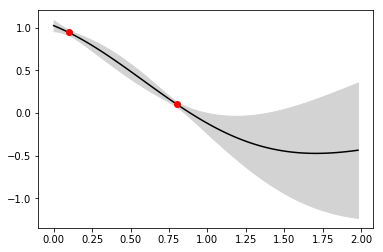

Initial Learning rates: [ 0.1  0.8]
Accuracy: [0.94419998, 0.1028]


In [14]:

sess = tf.InteractiveSession()
h_dim = 100 # Fixed number of hidden dimensions
n = 500 # Number of point in the grid.
xn = np.arange(0,2,10/n)

l_rates = np.array([0.1,0.8]) # Initial learning rates
f = [nn_train(l, h_dim) for l in tqdm(l_rates)] #Accuracy

noise = 1;length =1; m=0
m, noise, length, sf = opt_hyparams(l_rates,f)
E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
data = data_posterior(xn, E, cov)

#This plot shows the mean and variance with two initial observations:
plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)

Now we perform 5 interations. The figure below exhibits the learning rates selected by the algorithm with their corresponding accuracies. Additionally it shows the new mean and 1 standard deviation around the mean. 

  0%|          | 0/5 [00:00<?, ?it/s]

0: accuracy:0.12 loss: 229.232 (lr:0.0)
0: ********* epoch 1 ********* test accuracy:0.1336 test loss: 230.071
20: accuracy:0.13 loss: 230.084 (lr:0.0)
40: accuracy:0.1 loss: 230.391 (lr:0.0)
60: accuracy:0.1 loss: 230.533 (lr:0.0)
80: accuracy:0.13 loss: 229.909 (lr:0.0)
100: accuracy:0.12 loss: 229.779 (lr:0.0)
100: ********* epoch 1 ********* test accuracy:0.1336 test loss: 230.071
120: accuracy:0.09 loss: 231.054 (lr:0.0)
140: accuracy:0.06 loss: 231.455 (lr:0.0)
160: accuracy:0.17 loss: 229.183 (lr:0.0)
180: accuracy:0.16 loss: 230.024 (lr:0.0)
200: accuracy:0.14 loss: 230.721 (lr:0.0)
200: ********* epoch 1 ********* test accuracy:0.1336 test loss: 230.071
220: accuracy:0.14 loss: 230.439 (lr:0.0)
240: accuracy:0.17 loss: 229.997 (lr:0.0)
260: accuracy:0.13 loss: 230.728 (lr:0.0)
280: accuracy:0.12 loss: 229.538 (lr:0.0)
300: accuracy:0.07 loss: 231.737 (lr:0.0)
300: ********* epoch 1 ********* test accuracy:0.1336 test loss: 230.071
320: accuracy:0.18 loss: 228.794 (lr:0.0)
340:

2900: ********* epoch 5 ********* test accuracy:0.1336 test loss: 230.071
2920: accuracy:0.18 loss: 229.194 (lr:0.0)
2940: accuracy:0.14 loss: 229.674 (lr:0.0)
2960: accuracy:0.12 loss: 229.841 (lr:0.0)
2980: accuracy:0.13 loss: 230.542 (lr:0.0)
3000: accuracy:0.17 loss: 229.24 (lr:0.0)
3000: ********* epoch 6 ********* test accuracy:0.1336 test loss: 230.071
3020: accuracy:0.12 loss: 230.179 (lr:0.0)
3040: accuracy:0.09 loss: 231.035 (lr:0.0)
3060: accuracy:0.12 loss: 229.504 (lr:0.0)
3080: accuracy:0.19 loss: 228.02 (lr:0.0)
3100: accuracy:0.14 loss: 230.279 (lr:0.0)
3100: ********* epoch 6 ********* test accuracy:0.1336 test loss: 230.071
3120: accuracy:0.06 loss: 231.295 (lr:0.0)
3140: accuracy:0.14 loss: 229.602 (lr:0.0)
3160: accuracy:0.1 loss: 230.188 (lr:0.0)
3180: accuracy:0.12 loss: 230.298 (lr:0.0)
3200: accuracy:0.1 loss: 231.072 (lr:0.0)
3200: ********* epoch 6 ********* test accuracy:0.1336 test loss: 230.071
3220: accuracy:0.1 loss: 229.799 (lr:0.0)
3240: accuracy:0.13 l

5760: accuracy:0.15 loss: 229.427 (lr:0.0)
5780: accuracy:0.16 loss: 229.227 (lr:0.0)
5800: accuracy:0.11 loss: 229.527 (lr:0.0)
5800: ********* epoch 10 ********* test accuracy:0.1336 test loss: 230.071
5820: accuracy:0.17 loss: 230.128 (lr:0.0)
5840: accuracy:0.15 loss: 230.213 (lr:0.0)
5860: accuracy:0.12 loss: 229.504 (lr:0.0)
5880: accuracy:0.15 loss: 230.011 (lr:0.0)
5900: accuracy:0.08 loss: 230.556 (lr:0.0)
5900: ********* epoch 10 ********* test accuracy:0.1336 test loss: 230.071
5920: accuracy:0.18 loss: 228.958 (lr:0.0)
5940: accuracy:0.14 loss: 229.523 (lr:0.0)
5960: accuracy:0.12 loss: 229.786 (lr:0.0)
5980: accuracy:0.13 loss: 229.195 (lr:0.0)
6000: accuracy:0.13 loss: 229.149 (lr:0.0)
6000: ********* epoch 11 ********* test accuracy:0.1336 test loss: 230.071
6020: accuracy:0.14 loss: 229.437 (lr:0.0)
6040: accuracy:0.19 loss: 229.368 (lr:0.0)
6060: accuracy:0.1 loss: 230.35 (lr:0.0)
6080: accuracy:0.13 loss: 230.119 (lr:0.0)
6100: accuracy:0.12 loss: 230.535 (lr:0.0)
610

8600: ********* epoch 15 ********* test accuracy:0.1336 test loss: 230.071
8620: accuracy:0.12 loss: 229.921 (lr:0.0)
8640: accuracy:0.1 loss: 230.93 (lr:0.0)
8660: accuracy:0.19 loss: 229.834 (lr:0.0)
8680: accuracy:0.22 loss: 228.815 (lr:0.0)
8700: accuracy:0.15 loss: 230.303 (lr:0.0)
8700: ********* epoch 15 ********* test accuracy:0.1336 test loss: 230.071
8720: accuracy:0.15 loss: 229.509 (lr:0.0)
8740: accuracy:0.1 loss: 230.163 (lr:0.0)
8760: accuracy:0.07 loss: 230.761 (lr:0.0)
8780: accuracy:0.19 loss: 228.623 (lr:0.0)
8800: accuracy:0.16 loss: 229.475 (lr:0.0)
8800: ********* epoch 15 ********* test accuracy:0.1336 test loss: 230.071
8820: accuracy:0.12 loss: 229.793 (lr:0.0)
8840: accuracy:0.15 loss: 229.794 (lr:0.0)
8860: accuracy:0.14 loss: 229.294 (lr:0.0)
8880: accuracy:0.16 loss: 229.497 (lr:0.0)
8900: accuracy:0.14 loss: 228.966 (lr:0.0)
8900: ********* epoch 15 ********* test accuracy:0.1336 test loss: 230.071
8920: accuracy:0.09 loss: 230.197 (lr:0.0)
8940: accuracy:

 20%|██        | 1/5 [00:38<02:34, 38.60s/it]

0: accuracy:0.11 loss: 230.155 (lr:0.38)
0: ********* epoch 1 ********* test accuracy:0.1326 test loss: 230.021
20: accuracy:0.1 loss: 236.115 (lr:0.38)
40: accuracy:0.07 loss: 239.115 (lr:0.38)
60: accuracy:0.07 loss: 239.115 (lr:0.38)
80: accuracy:0.06 loss: 240.115 (lr:0.38)
100: accuracy:0.15 loss: 231.115 (lr:0.38)
100: ********* epoch 1 ********* test accuracy:0.1028 test loss: 235.83
120: accuracy:0.11 loss: 235.115 (lr:0.38)
140: accuracy:0.11 loss: 235.115 (lr:0.38)
160: accuracy:0.12 loss: 234.115 (lr:0.38)
180: accuracy:0.14 loss: 232.115 (lr:0.38)
200: accuracy:0.09 loss: 237.115 (lr:0.38)
200: ********* epoch 1 ********* test accuracy:0.1028 test loss: 235.83
220: accuracy:0.1 loss: 236.115 (lr:0.38)
240: accuracy:0.1 loss: 236.115 (lr:0.38)
260: accuracy:0.11 loss: 235.115 (lr:0.38)
280: accuracy:0.08 loss: 238.115 (lr:0.38)
300: accuracy:0.13 loss: 233.115 (lr:0.38)
300: ********* epoch 1 ********* test accuracy:0.1028 test loss: 235.83
320: accuracy:0.09 loss: 237.115 (

2840: accuracy:0.08 loss: 238.115 (lr:0.38)
2860: accuracy:0.09 loss: 237.115 (lr:0.38)
2880: accuracy:0.07 loss: 239.115 (lr:0.38)
2900: accuracy:0.12 loss: 234.115 (lr:0.38)
2900: ********* epoch 5 ********* test accuracy:0.1028 test loss: 235.83
2920: accuracy:0.13 loss: 233.115 (lr:0.38)
2940: accuracy:0.1 loss: 236.115 (lr:0.38)
2960: accuracy:0.13 loss: 233.115 (lr:0.38)
2980: accuracy:0.09 loss: 237.115 (lr:0.38)
3000: accuracy:0.15 loss: 231.115 (lr:0.38)
3000: ********* epoch 6 ********* test accuracy:0.1028 test loss: 235.83
3020: accuracy:0.06 loss: 240.115 (lr:0.38)
3040: accuracy:0.15 loss: 231.115 (lr:0.38)
3060: accuracy:0.13 loss: 233.115 (lr:0.38)
3080: accuracy:0.13 loss: 233.115 (lr:0.38)
3100: accuracy:0.09 loss: 237.115 (lr:0.38)
3100: ********* epoch 6 ********* test accuracy:0.1028 test loss: 235.83
3120: accuracy:0.18 loss: 228.115 (lr:0.38)
3140: accuracy:0.15 loss: 231.115 (lr:0.38)
3160: accuracy:0.15 loss: 231.115 (lr:0.38)
3180: accuracy:0.12 loss: 234.115 

5700: accuracy:0.07 loss: 239.115 (lr:0.38)
5700: ********* epoch 10 ********* test accuracy:0.1028 test loss: 235.83
5720: accuracy:0.11 loss: 235.115 (lr:0.38)
5740: accuracy:0.11 loss: 235.115 (lr:0.38)
5760: accuracy:0.08 loss: 238.115 (lr:0.38)
5780: accuracy:0.03 loss: 243.115 (lr:0.38)
5800: accuracy:0.1 loss: 236.115 (lr:0.38)
5800: ********* epoch 10 ********* test accuracy:0.1028 test loss: 235.83
5820: accuracy:0.13 loss: 233.115 (lr:0.38)
5840: accuracy:0.1 loss: 236.115 (lr:0.38)
5860: accuracy:0.17 loss: 229.115 (lr:0.38)
5880: accuracy:0.1 loss: 236.115 (lr:0.38)
5900: accuracy:0.08 loss: 238.115 (lr:0.38)
5900: ********* epoch 10 ********* test accuracy:0.1028 test loss: 235.83
5920: accuracy:0.09 loss: 237.115 (lr:0.38)
5940: accuracy:0.07 loss: 239.115 (lr:0.38)
5960: accuracy:0.15 loss: 231.115 (lr:0.38)
5980: accuracy:0.09 loss: 237.115 (lr:0.38)
6000: accuracy:0.08 loss: 238.115 (lr:0.38)
6000: ********* epoch 11 ********* test accuracy:0.1028 test loss: 235.83
602

8500: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8520: accuracy:0.09 loss: 237.115 (lr:0.38)
8540: accuracy:0.08 loss: 238.115 (lr:0.38)
8560: accuracy:0.08 loss: 238.115 (lr:0.38)
8580: accuracy:0.12 loss: 234.115 (lr:0.38)
8600: accuracy:0.07 loss: 239.115 (lr:0.38)
8600: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8620: accuracy:0.1 loss: 236.115 (lr:0.38)
8640: accuracy:0.06 loss: 240.115 (lr:0.38)
8660: accuracy:0.08 loss: 238.115 (lr:0.38)
8680: accuracy:0.08 loss: 238.115 (lr:0.38)
8700: accuracy:0.05 loss: 241.115 (lr:0.38)
8700: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8720: accuracy:0.17 loss: 229.115 (lr:0.38)
8740: accuracy:0.04 loss: 242.115 (lr:0.38)
8760: accuracy:0.17 loss: 229.115 (lr:0.38)
8780: accuracy:0.05 loss: 241.115 (lr:0.38)
8800: accuracy:0.05 loss: 241.115 (lr:0.38)
8800: ********* epoch 15 ********* test accuracy:0.1028 test loss: 235.83
8820: accuracy:0.11 loss: 235.115 (lr:0.38)
8

 40%|████      | 2/5 [01:15<01:53, 37.95s/it]

0: accuracy:0.1 loss: 230.736 (lr:0.2)
0: ********* epoch 1 ********* test accuracy:0.0932 test loss: 230.609
20: accuracy:0.1 loss: 236.115 (lr:0.2)
40: accuracy:0.1 loss: 236.115 (lr:0.2)
60: accuracy:0.1 loss: 236.115 (lr:0.2)
80: accuracy:0.06 loss: 240.115 (lr:0.2)
100: accuracy:0.15 loss: 231.115 (lr:0.2)
100: ********* epoch 1 ********* test accuracy:0.101 test loss: 236.01
120: accuracy:0.13 loss: 233.115 (lr:0.2)
140: accuracy:0.06 loss: 240.115 (lr:0.2)
160: accuracy:0.05 loss: 241.115 (lr:0.2)
180: accuracy:0.06 loss: 240.115 (lr:0.2)
200: accuracy:0.11 loss: 235.115 (lr:0.2)
200: ********* epoch 1 ********* test accuracy:0.101 test loss: 236.01
220: accuracy:0.15 loss: 231.115 (lr:0.2)
240: accuracy:0.09 loss: 237.115 (lr:0.2)
260: accuracy:0.09 loss: 236.796 (lr:0.2)
280: accuracy:0.28 loss: 217.911 (lr:0.2)
300: accuracy:0.36 loss: 210.116 (lr:0.2)
300: ********* epoch 1 ********* test accuracy:0.3918 test loss: 206.747
320: accuracy:0.34 loss: 212.065 (lr:0.2)
340: accur

2880: accuracy:0.45 loss: 201.106 (lr:0.2)
2900: accuracy:0.42 loss: 204.089 (lr:0.2)
2900: ********* epoch 5 ********* test accuracy:0.4485 test loss: 201.258
2920: accuracy:0.52 loss: 194.107 (lr:0.2)
2940: accuracy:0.5 loss: 196.115 (lr:0.2)
2960: accuracy:0.54 loss: 192.099 (lr:0.2)
2980: accuracy:0.5 loss: 196.083 (lr:0.2)
3000: accuracy:0.49 loss: 197.243 (lr:0.2)
3000: ********* epoch 6 ********* test accuracy:0.4815 test loss: 197.948
3020: accuracy:0.52 loss: 194.115 (lr:0.2)
3040: accuracy:0.38 loss: 208.114 (lr:0.2)
3060: accuracy:0.5 loss: 195.908 (lr:0.2)
3080: accuracy:0.42 loss: 204.066 (lr:0.2)
3100: accuracy:0.5 loss: 196.114 (lr:0.2)
3100: ********* epoch 6 ********* test accuracy:0.4805 test loss: 198.042
3120: accuracy:0.54 loss: 192.098 (lr:0.2)
3140: accuracy:0.48 loss: 198.112 (lr:0.2)
3160: accuracy:0.46 loss: 200.115 (lr:0.2)
3180: accuracy:0.52 loss: 194.115 (lr:0.2)
3200: accuracy:0.39 loss: 207.083 (lr:0.2)
3200: ********* epoch 6 ********* test accuracy:0.4

5760: accuracy:0.56 loss: 190.107 (lr:0.2)
5780: accuracy:0.48 loss: 198.083 (lr:0.2)
5800: accuracy:0.45 loss: 201.118 (lr:0.2)
5800: ********* epoch 10 ********* test accuracy:0.4817 test loss: 197.935
5820: accuracy:0.51 loss: 195.115 (lr:0.2)
5840: accuracy:0.49 loss: 197.115 (lr:0.2)
5860: accuracy:0.54 loss: 192.115 (lr:0.2)
5880: accuracy:0.47 loss: 199.115 (lr:0.2)
5900: accuracy:0.41 loss: 205.115 (lr:0.2)
5900: ********* epoch 10 ********* test accuracy:0.4848 test loss: 197.629
5920: accuracy:0.52 loss: 194.115 (lr:0.2)
5940: accuracy:0.52 loss: 194.115 (lr:0.2)
5960: accuracy:0.46 loss: 200.095 (lr:0.2)
5980: accuracy:0.57 loss: 189.115 (lr:0.2)
6000: accuracy:0.51 loss: 195.115 (lr:0.2)
6000: ********* epoch 11 ********* test accuracy:0.4744 test loss: 198.667
6020: accuracy:0.44 loss: 202.12 (lr:0.2)
6040: accuracy:0.48 loss: 198.115 (lr:0.2)
6060: accuracy:0.49 loss: 197.115 (lr:0.2)
6080: accuracy:0.5 loss: 196.073 (lr:0.2)
6100: accuracy:0.41 loss: 205.115 (lr:0.2)
610

8620: accuracy:0.53 loss: 193.107 (lr:0.2)
8640: accuracy:0.49 loss: 197.115 (lr:0.2)
8660: accuracy:0.48 loss: 198.064 (lr:0.2)
8680: accuracy:0.55 loss: 191.115 (lr:0.2)
8700: accuracy:0.6 loss: 186.115 (lr:0.2)
8700: ********* epoch 15 ********* test accuracy:0.4686 test loss: 199.251
8720: accuracy:0.53 loss: 193.099 (lr:0.2)
8740: accuracy:0.38 loss: 208.107 (lr:0.2)
8760: accuracy:0.5 loss: 196.115 (lr:0.2)
8780: accuracy:0.48 loss: 198.13 (lr:0.2)
8800: accuracy:0.54 loss: 192.124 (lr:0.2)
8800: ********* epoch 15 ********* test accuracy:0.4781 test loss: 198.302
8820: accuracy:0.52 loss: 194.115 (lr:0.2)
8840: accuracy:0.5 loss: 196.101 (lr:0.2)
8860: accuracy:0.52 loss: 194.115 (lr:0.2)
8880: accuracy:0.47 loss: 199.115 (lr:0.2)
8900: accuracy:0.61 loss: 185.115 (lr:0.2)
8900: ********* epoch 15 ********* test accuracy:0.4695 test loss: 199.156
8920: accuracy:0.34 loss: 212.099 (lr:0.2)
8940: accuracy:0.46 loss: 200.078 (lr:0.2)
8960: accuracy:0.5 loss: 196.115 (lr:0.2)
8980: 

 60%|██████    | 3/5 [01:48<01:12, 36.48s/it]

10000: ********* epoch 17 ********* test accuracy:0.4839 test loss: 197.716
0: accuracy:0.1 loss: 230.797 (lr:0.58)
0: ********* epoch 1 ********* test accuracy:0.0835 test loss: 230.822
20: accuracy:0.14 loss: 232.115 (lr:0.58)
40: accuracy:0.13 loss: 233.115 (lr:0.58)
60: accuracy:0.13 loss: 233.115 (lr:0.58)
80: accuracy:0.13 loss: 233.115 (lr:0.58)
100: accuracy:0.07 loss: 239.115 (lr:0.58)
100: ********* epoch 1 ********* test accuracy:0.1135 test loss: 234.76
120: accuracy:0.05 loss: 241.115 (lr:0.58)
140: accuracy:0.1 loss: 236.115 (lr:0.58)
160: accuracy:0.11 loss: 235.115 (lr:0.58)
180: accuracy:0.06 loss: 240.115 (lr:0.58)
200: accuracy:0.08 loss: 238.115 (lr:0.58)
200: ********* epoch 1 ********* test accuracy:0.1135 test loss: 234.76
220: accuracy:0.07 loss: 239.115 (lr:0.58)
240: accuracy:0.11 loss: 235.115 (lr:0.58)
260: accuracy:0.13 loss: 233.115 (lr:0.58)
280: accuracy:0.12 loss: 234.115 (lr:0.58)
300: accuracy:0.14 loss: 232.115 (lr:0.58)
300: ********* epoch 1 ******

2820: accuracy:0.05 loss: 241.115 (lr:0.58)
2840: accuracy:0.13 loss: 233.115 (lr:0.58)
2860: accuracy:0.09 loss: 237.115 (lr:0.58)
2880: accuracy:0.1 loss: 236.115 (lr:0.58)
2900: accuracy:0.15 loss: 231.115 (lr:0.58)
2900: ********* epoch 5 ********* test accuracy:0.1135 test loss: 234.76
2920: accuracy:0.07 loss: 239.115 (lr:0.58)
2940: accuracy:0.14 loss: 232.115 (lr:0.58)
2960: accuracy:0.08 loss: 238.115 (lr:0.58)
2980: accuracy:0.09 loss: 237.115 (lr:0.58)
3000: accuracy:0.12 loss: 234.115 (lr:0.58)
3000: ********* epoch 6 ********* test accuracy:0.1135 test loss: 234.76
3020: accuracy:0.1 loss: 236.115 (lr:0.58)
3040: accuracy:0.05 loss: 241.115 (lr:0.58)
3060: accuracy:0.14 loss: 232.115 (lr:0.58)
3080: accuracy:0.16 loss: 230.115 (lr:0.58)
3100: accuracy:0.13 loss: 233.115 (lr:0.58)
3100: ********* epoch 6 ********* test accuracy:0.1135 test loss: 234.76
3120: accuracy:0.16 loss: 230.115 (lr:0.58)
3140: accuracy:0.1 loss: 236.115 (lr:0.58)
3160: accuracy:0.09 loss: 237.115 (l

5680: accuracy:0.13 loss: 233.115 (lr:0.58)
5700: accuracy:0.11 loss: 235.115 (lr:0.58)
5700: ********* epoch 10 ********* test accuracy:0.1135 test loss: 234.76
5720: accuracy:0.11 loss: 235.115 (lr:0.58)
5740: accuracy:0.1 loss: 236.115 (lr:0.58)
5760: accuracy:0.08 loss: 238.115 (lr:0.58)
5780: accuracy:0.09 loss: 237.115 (lr:0.58)
5800: accuracy:0.13 loss: 233.115 (lr:0.58)
5800: ********* epoch 10 ********* test accuracy:0.1135 test loss: 234.76
5820: accuracy:0.13 loss: 233.115 (lr:0.58)
5840: accuracy:0.06 loss: 240.115 (lr:0.58)
5860: accuracy:0.06 loss: 240.115 (lr:0.58)
5880: accuracy:0.07 loss: 239.115 (lr:0.58)
5900: accuracy:0.12 loss: 234.115 (lr:0.58)
5900: ********* epoch 10 ********* test accuracy:0.1135 test loss: 234.76
5920: accuracy:0.13 loss: 233.115 (lr:0.58)
5940: accuracy:0.15 loss: 231.115 (lr:0.58)
5960: accuracy:0.07 loss: 239.115 (lr:0.58)
5980: accuracy:0.11 loss: 235.115 (lr:0.58)
6000: accuracy:0.13 loss: 233.115 (lr:0.58)
6000: ********* epoch 11 ******

8480: accuracy:0.08 loss: 238.115 (lr:0.58)
8500: accuracy:0.14 loss: 232.115 (lr:0.58)
8500: ********* epoch 15 ********* test accuracy:0.1135 test loss: 234.76
8520: accuracy:0.13 loss: 233.115 (lr:0.58)
8540: accuracy:0.11 loss: 235.115 (lr:0.58)
8560: accuracy:0.11 loss: 235.115 (lr:0.58)
8580: accuracy:0.13 loss: 233.115 (lr:0.58)
8600: accuracy:0.13 loss: 233.115 (lr:0.58)
8600: ********* epoch 15 ********* test accuracy:0.1135 test loss: 234.76
8620: accuracy:0.05 loss: 241.115 (lr:0.58)
8640: accuracy:0.13 loss: 233.115 (lr:0.58)
8660: accuracy:0.15 loss: 231.115 (lr:0.58)
8680: accuracy:0.07 loss: 239.115 (lr:0.58)
8700: accuracy:0.03 loss: 243.115 (lr:0.58)
8700: ********* epoch 15 ********* test accuracy:0.1135 test loss: 234.76
8720: accuracy:0.13 loss: 233.115 (lr:0.58)
8740: accuracy:0.12 loss: 234.115 (lr:0.58)
8760: accuracy:0.1 loss: 236.115 (lr:0.58)
8780: accuracy:0.1 loss: 236.115 (lr:0.58)
8800: accuracy:0.07 loss: 239.115 (lr:0.58)
8800: ********* epoch 15 *******

 80%|████████  | 4/5 [02:20<00:35, 35.14s/it]

0: accuracy:0.15 loss: 230.096 (lr:1.06)
0: ********* epoch 1 ********* test accuracy:0.1104 test loss: 230.636
20: accuracy:0.09 loss: 237.115 (lr:1.06)
40: accuracy:0.08 loss: 238.115 (lr:1.06)
60: accuracy:0.11 loss: 235.115 (lr:1.06)
80: accuracy:0.08 loss: 238.115 (lr:1.06)
100: accuracy:0.08 loss: 238.115 (lr:1.06)
100: ********* epoch 1 ********* test accuracy:0.0974 test loss: 236.37
120: accuracy:0.11 loss: 235.115 (lr:1.06)
140: accuracy:0.07 loss: 239.115 (lr:1.06)
160: accuracy:0.03 loss: 243.115 (lr:1.06)
180: accuracy:0.07 loss: 239.115 (lr:1.06)
200: accuracy:0.14 loss: 232.115 (lr:1.06)
200: ********* epoch 1 ********* test accuracy:0.0974 test loss: 236.37
220: accuracy:0.03 loss: 243.115 (lr:1.06)
240: accuracy:0.05 loss: 241.115 (lr:1.06)
260: accuracy:0.12 loss: 234.115 (lr:1.06)
280: accuracy:0.07 loss: 239.115 (lr:1.06)
300: accuracy:0.21 loss: 225.115 (lr:1.06)
300: ********* epoch 1 ********* test accuracy:0.0974 test loss: 236.37
320: accuracy:0.07 loss: 239.11

2840: accuracy:0.1 loss: 236.115 (lr:1.06)
2860: accuracy:0.06 loss: 240.115 (lr:1.06)
2880: accuracy:0.05 loss: 241.115 (lr:1.06)
2900: accuracy:0.13 loss: 233.115 (lr:1.06)
2900: ********* epoch 5 ********* test accuracy:0.0974 test loss: 236.37
2920: accuracy:0.13 loss: 233.115 (lr:1.06)
2940: accuracy:0.05 loss: 241.115 (lr:1.06)
2960: accuracy:0.12 loss: 234.115 (lr:1.06)
2980: accuracy:0.1 loss: 236.115 (lr:1.06)
3000: accuracy:0.11 loss: 235.115 (lr:1.06)
3000: ********* epoch 6 ********* test accuracy:0.0974 test loss: 236.37
3020: accuracy:0.11 loss: 235.115 (lr:1.06)
3040: accuracy:0.07 loss: 239.115 (lr:1.06)
3060: accuracy:0.14 loss: 232.115 (lr:1.06)
3080: accuracy:0.14 loss: 232.115 (lr:1.06)
3100: accuracy:0.08 loss: 238.115 (lr:1.06)
3100: ********* epoch 6 ********* test accuracy:0.0974 test loss: 236.37
3120: accuracy:0.07 loss: 239.115 (lr:1.06)
3140: accuracy:0.14 loss: 232.115 (lr:1.06)
3160: accuracy:0.09 loss: 237.115 (lr:1.06)
3180: accuracy:0.09 loss: 237.115 (

5680: accuracy:0.1 loss: 236.115 (lr:1.06)
5700: accuracy:0.09 loss: 237.115 (lr:1.06)
5700: ********* epoch 10 ********* test accuracy:0.0974 test loss: 236.37
5720: accuracy:0.09 loss: 237.115 (lr:1.06)
5740: accuracy:0.12 loss: 234.115 (lr:1.06)
5760: accuracy:0.09 loss: 237.115 (lr:1.06)
5780: accuracy:0.16 loss: 230.115 (lr:1.06)
5800: accuracy:0.15 loss: 231.115 (lr:1.06)
5800: ********* epoch 10 ********* test accuracy:0.0974 test loss: 236.37
5820: accuracy:0.08 loss: 238.115 (lr:1.06)
5840: accuracy:0.14 loss: 232.115 (lr:1.06)
5860: accuracy:0.08 loss: 238.115 (lr:1.06)
5880: accuracy:0.11 loss: 235.115 (lr:1.06)
5900: accuracy:0.12 loss: 234.115 (lr:1.06)
5900: ********* epoch 10 ********* test accuracy:0.0974 test loss: 236.37
5920: accuracy:0.1 loss: 236.115 (lr:1.06)
5940: accuracy:0.11 loss: 235.115 (lr:1.06)
5960: accuracy:0.11 loss: 235.115 (lr:1.06)
5980: accuracy:0.07 loss: 239.115 (lr:1.06)
6000: accuracy:0.09 loss: 237.115 (lr:1.06)
6000: ********* epoch 11 *******

8520: accuracy:0.04 loss: 242.115 (lr:1.06)
8540: accuracy:0.15 loss: 231.115 (lr:1.06)
8560: accuracy:0.08 loss: 238.115 (lr:1.06)
8580: accuracy:0.05 loss: 241.115 (lr:1.06)
8600: accuracy:0.09 loss: 237.115 (lr:1.06)
8600: ********* epoch 15 ********* test accuracy:0.0974 test loss: 236.37
8620: accuracy:0.07 loss: 239.115 (lr:1.06)
8640: accuracy:0.14 loss: 232.115 (lr:1.06)
8660: accuracy:0.06 loss: 240.115 (lr:1.06)
8680: accuracy:0.06 loss: 240.115 (lr:1.06)
8700: accuracy:0.15 loss: 231.115 (lr:1.06)
8700: ********* epoch 15 ********* test accuracy:0.0974 test loss: 236.37
8720: accuracy:0.07 loss: 239.115 (lr:1.06)
8740: accuracy:0.14 loss: 232.115 (lr:1.06)
8760: accuracy:0.11 loss: 235.115 (lr:1.06)
8780: accuracy:0.13 loss: 233.115 (lr:1.06)
8800: accuracy:0.09 loss: 237.115 (lr:1.06)
8800: ********* epoch 15 ********* test accuracy:0.0974 test loss: 236.37
8820: accuracy:0.12 loss: 234.115 (lr:1.06)
8840: accuracy:0.13 loss: 233.115 (lr:1.06)
8860: accuracy:0.07 loss: 239.

100%|██████████| 5/5 [02:54<00:00, 34.81s/it]


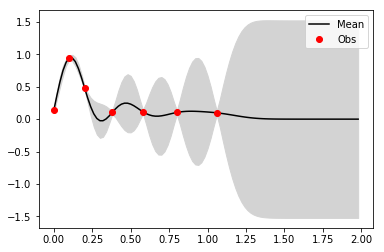

Initial Learning rates: [ 0.1   0.8   0.    0.38  0.2   0.58  1.06]
Accuracy: [ 0.94419998  0.1028      0.1336      0.1028      0.48390001  0.1135
  0.0974    ]


In [15]:
#If sf is used, we have to use opt_hyparams_noise, otherwise use opt_hyparams. 
n_iter = 5

for i in tqdm(range(n_iter)):
    next_candidate = acquisition_fun(l_rates, f, xn, np.array(data['Mean']), np.array(data['StdDev']))
    l_rates = np.append(l_rates,next_candidate)
    f = np.append(f,nn_train(next_candidate, h_dim))
    E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
    data = data_posterior(xn, E, cov)

    try:
        m, noise, length, sf = opt_hyparams(l_rates,f)
    except ValueError:
        m, noise, length, sf = m, noise, length, sf


plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')

plt.legend()
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)


From the plot, we observe how the algorithm explores the domain of the hyperparameter, searching for the most appropiate learning rate. In this examples the initial learning rates are 0.1 and 8. After 5 interations the algorithm recomends a learning rate that allows to increase the accuracy from the region in [0.9, 0.92] to [0.93, 0.95].

## Accuracy evaluation with decaying learning rate - w/o bayesian optimisation

In [16]:
sess = tf.InteractiveSession()
%time nn_train_var(min_lr=0.0001, max_lr=0.003, h_dim=100, minibatch = 100)

0: accuracy:0.1 loss: 228.615 (lr:0.003)
0: ********* epoch 1 ********* test accuracy:0.081 test loss: 230.111
20: accuracy:0.42 loss: 220.247 (lr:0.0029711445178725875)
40: accuracy:0.46 loss: 206.584 (lr:0.0029425761525895904)
60: accuracy:0.45 loss: 204.837 (lr:0.0029142920472906737)
80: accuracy:0.72 loss: 186.098 (lr:0.0028862893735417373)
100: accuracy:0.85 loss: 176.142 (lr:0.0028585653310520707)
100: ********* epoch 1 ********* test accuracy:0.7678 test loss: 179.246
120: accuracy:0.73 loss: 180.379 (lr:0.0028311171473943213)
140: accuracy:0.77 loss: 175.923 (lr:0.0028039420777272502)
160: accuracy:0.73 loss: 176.193 (lr:0.0027770374045212438)
180: accuracy:0.77 loss: 175.147 (lr:0.0027504004372865616)
200: accuracy:0.78 loss: 170.835 (lr:0.0027240285123042826)
200: ********* epoch 1 ********* test accuracy:0.8009 test loss: 169.799
220: accuracy:0.74 loss: 175.683 (lr:0.0026979189923599317)
240: accuracy:0.82 loss: 166.903 (lr:0.0026720692664797567)
260: accuracy:0.75 loss: 17

2200: accuracy:0.83 loss: 163.989 (lr:0.0010653261427244307)
2200: ********* epoch 4 ********* test accuracy:0.8416 test loss: 162.366
2220: accuracy:0.85 loss: 161.043 (lr:0.0010557209871180483)
2240: accuracy:0.86 loss: 159.05 (lr:0.0010462114044068145)
2260: accuracy:0.94 loss: 155.533 (lr:0.0010367964436245336)
2280: accuracy:0.91 loss: 157.154 (lr:0.0010274751632672816)
2300: accuracy:0.89 loss: 157.604 (lr:0.0010182466311992545)
2300: ********* epoch 4 ********* test accuracy:0.9106 test loss: 157.22
2320: accuracy:0.9 loss: 158.618 (lr:0.0010091099245595554)
2340: accuracy:0.93 loss: 154.46 (lr:0.0010000641296699067)
2360: accuracy:0.86 loss: 159.863 (lr:0.0009911083419432806)
2380: accuracy:0.9 loss: 157.52 (lr:0.0009822416657934419)
2400: accuracy:0.96 loss: 153.707 (lr:0.0009734632145453863)
2400: ********* epoch 5 ********* test accuracy:0.921 test loss: 156.116
2420: accuracy:0.88 loss: 159.921 (lr:0.0009647721103466736)
2440: accuracy:0.95 loss: 155.258 (lr:0.0009561674840

4400: ********* epoch 8 ********* test accuracy:0.9316 test loss: 154.063
4420: accuracy:0.93 loss: 154.076 (lr:0.0004181318806949831)
4440: accuracy:0.96 loss: 150.495 (lr:0.0004149664155923781)
4460: accuracy:0.91 loss: 156.952 (lr:0.0004118324473938054)
4480: accuracy:0.93 loss: 154.12 (lr:0.00040872966269983314)
4500: accuracy:0.88 loss: 157.642 (lr:0.00040565775122940656)
4500: ********* epoch 8 ********* test accuracy:0.9322 test loss: 154.027
4520: accuracy:0.92 loss: 154.543 (lr:0.0004026164057888186)
4540: accuracy:0.92 loss: 153.301 (lr:0.0003996053222409906)
4560: accuracy:0.94 loss: 153.567 (lr:0.0003966241994750587)
4580: accuracy:0.94 loss: 152.918 (lr:0.00039367273937626184)
4600: accuracy:0.94 loss: 154.191 (lr:0.0003907506467961309)
4600: ********* epoch 8 ********* test accuracy:0.9314 test loss: 153.988
4620: accuracy:0.96 loss: 151.415 (lr:0.0003878576295229724)
4640: accuracy:0.94 loss: 151.979 (lr:0.0003849933982526485)
4660: accuracy:0.97 loss: 151.275 (lr:0.0003

6600: ********* epoch 12 ********* test accuracy:0.9353 test loss: 153.657
6620: accuracy:0.93 loss: 154.196 (lr:0.00020589690388584717)
6640: accuracy:0.9 loss: 154.79 (lr:0.00020484321208673464)
6660: accuracy:0.93 loss: 154.172 (lr:0.00020380000469620037)
6680: accuracy:0.96 loss: 151.735 (lr:0.00020276717739263608)
6700: accuracy:0.92 loss: 154.758 (lr:0.0002017446268924506)
6700: ********* epoch 12 ********* test accuracy:0.9349 test loss: 153.633
6720: accuracy:0.95 loss: 152.299 (lr:0.00020073225093974185)
6740: accuracy:0.93 loss: 154.61 (lr:0.00019972994829607087)
6760: accuracy:0.93 loss: 153.274 (lr:0.00019873761873033811)
6780: accuracy:0.92 loss: 155.307 (lr:0.00019775516300875995)
6800: accuracy:0.99 loss: 149.426 (lr:0.00019678248288494563)
6800: ********* epoch 12 ********* test accuracy:0.9351 test loss: 153.62
6820: accuracy:0.89 loss: 156.891 (lr:0.00019581948109007212)
6840: accuracy:0.97 loss: 151.286 (lr:0.0001948660613231575)
6860: accuracy:0.96 loss: 151.446 (lr

8800: accuracy:0.9 loss: 155.277 (lr:0.00013560428571889846)
8800: ********* epoch 15 ********* test accuracy:0.9364 test loss: 153.462
8820: accuracy:0.91 loss: 156.258 (lr:0.00013525001715675332)
8840: accuracy:0.89 loss: 157.56 (lr:0.00013489927362569896)
8860: accuracy:0.92 loss: 154.976 (lr:0.00013455202005109)
8880: accuracy:0.92 loss: 154.798 (lr:0.00013420822170727954)
8900: accuracy:0.93 loss: 152.777 (lr:0.0001338678442141468)
8900: ********* epoch 15 ********* test accuracy:0.936 test loss: 153.467
8920: accuracy:0.87 loss: 159.46 (lr:0.00013353085353365877)
8940: accuracy:0.94 loss: 153.008 (lr:0.00013319721596646657)
8960: accuracy:0.95 loss: 151.942 (lr:0.00013286689814853543)
8980: accuracy:0.89 loss: 158.188 (lr:0.00013253986704780835)
9000: accuracy:0.97 loss: 149.958 (lr:0.0001322160899609027)
9000: ********* epoch 16 ********* test accuracy:0.9359 test loss: 153.457
9020: accuracy:0.96 loss: 151.665 (lr:0.00013189553450983996)
9040: accuracy:0.95 loss: 152.829 (lr:0.

0.93709999